In [96]:
# DASK imports
import sys
from dask.distributed import Client
from dask import delayed
import dask.array as da, dask.dataframe as dd
from distributed import Client
from dask_saturn import SaturnCluster
import dask 

# Dask ML imports
from dask_ml.cluster import KMeans as dask_Kmeans
from dask_ml.decomposition import TruncatedSVD

# Scikit imports
from sklearn.cluster import KMeans

# miscc imports
import time
import numpy as np
import pandas as pd
import timeit

# Scanpy imports 
import scanpy as sc

# plotting code
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [12]:
! pip install scanpy
! pip install dask-saturn
! pip install dask_ml

Load up a Pancreas cell dataset provided by Scanpy 

In [10]:
adata_all = sc.read('data/pancreas.h5ad')


# Scanpy meets Dask 

In [67]:
adata_all

AnnData object with n_obs × n_vars = 14693 × 2448 
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

Scanpy revolves around Anndata objects -- these are great because of the easily extensible/domain specific visualization/preprocessing capabilities.

For example, this Scanpy plot gives me a really clear picture of the composition of my Pancreas cell data 

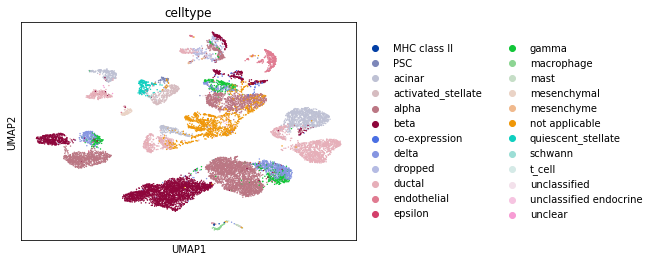

In [11]:
sc.pl.umap(adata_all, color=['celltype'], palette=sc.pl.palettes.zeileis_28)

But what if I want to cluster this cellular data outside of the methods available within Scanpy? In the first section of is notebook we will leverage a familiar API, Scikit learn, to build an initial Kmeans model, and in the latter portion I will showcase how Dask can talk to scikit-learn (via joblib)-- this is a really performant way to do things like grid-search over many hyper-parameters, or in our case determine the optimal number of clusters for our K-means model.

In [13]:
adata_all_df = adata_all.to_df()

In [13]:
# adata_all_dd = dd.from_pandas(adata_all_df, npartitions=3)

# Kmeans 

Let's train a kmeans model using the cell data: 

In [15]:
true_k = 10
km_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=2, random_state=42).fit(adata_all_df)
clusters = km_model.labels_.tolist()

In [16]:
km_model.cluster_centers_

array([[-0.14158581,  0.17651169, -0.05134734, ..., -0.11207858,
        -0.1223592 ,  0.63952583],
       [-0.14750203, -0.33349633, -0.00461841, ...,  0.22903065,
         0.06629614, -0.11704953],
       [-0.16056453,  0.36354876,  0.01874879, ...,  0.38454303,
         0.312119  , -0.11668202],
       ...,
       [ 1.4627358 , -0.3570995 , -0.21271273, ..., -0.1762867 ,
        -0.1223592 , -0.09854349],
       [-0.17909378, -0.01089864, -0.13486122, ..., -0.17348653,
        -0.11715783, -0.11703684],
       [-0.17054565, -0.35345212, -0.13666336, ..., -0.18185121,
        -0.11151371, -0.09706986]], dtype=float32)

In [17]:
km_preds = km_model.predict(adata_all_df)
km_preds_df = pd.DataFrame(km_preds)
km_preds_df.columns = ['cluster']
km_preds_df.iloc[:,0].value_counts()

8    5991
2    3220
5    1779
9    1002
1     579
4     546
3     534
6     464
0     297
7     281
Name: cluster, dtype: int64

Ok great we have some clusters (0-9) and some data, but who's to say that this is the optimal number of clusters given our dataset? 

K-means clustering is one of the most simple clustering algorithms.  However, one of its' limitations is that it depends on the number of clusters need to be defined beforehand. I just arbitrarily chose 10 as our number of clusters (the true_k variable above) but I have no idea if that's really the optimal number of clusters given our cell data. 

A way of determining the optimal number of clusters is to plot the inertia (sum of squared error between each point and its cluster center) as a function of the number of clusters -- for this notebook, I will focus on just getting inertia calculated first. 

# Determine optimal n-clusters

let's try running a search for the optimal number of clusters from 1 to 20 just to be thorough. I'm also using all cores of my machine by specifying ```n_jobs=-1.``` 


In [36]:
%%timeit

inertia = []
list_num_clusters = list(range(1,20))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=2, random_state=50, n_jobs=-1)
    km.fit(adata_all_df)
    inertia.append(km.inertia_)

Well this sounded like a good optimization strategy for our Kmeans, but trying to run the code above is taking too long. Instead of using Kmeans from scikit, let's try running the same code again, but this time employing Dask-ML's Kmeans instead. 

# Determine optimal n-clusters -- much faster

Setup our [Saturn cluster]('http://docs.saturncloud.io/en/articles/3652101-spin-up-dask-on-saturn')

In [1]:
cluster = SaturnCluster()
cluster

In [63]:
client = Client(cluster)

In [ ]:
cluster.status

In [87]:
%%timeit

inertia = []
list_num_clusters = list(range(1,20))
for num_clusters in list_num_clusters:
    dask_km = dask_Kmeans(n_clusters=num_clusters, init='k-means++', max_iter=2, random_state=50)
    dask_km.fit(adata_all_df)
    inertia.append(dask_km.inertia_)

15min 17s ± 3.82 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now we will plot the inertia as a function of the number of clusters 

In [101]:
# df > dd
adata_dd = dd.from_pandas(adata_all_df, npartitions=3)

In [104]:
# dd > da
adata_da = adata_dd.to_dask_array()

In [106]:
# shrinking the data down to 2 dims using Dasks truncated SVD 

svd = TruncatedSVD(2)
trans_data = svd.fit_transform(adata_da)

ValueError: x and y must have same first dimension, but have shapes (19,) and (5,)

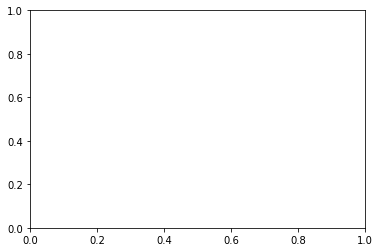

In [95]:
# plt.plot(list_num_clusters,inertia)
# plt.scatter(list_num_clusters,inertia)
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia');

In [111]:
inertia[0:10] 

[30118492.11694521,
 638931.9068355246,
 630648.623417645,
 627987.5527345949,
 626829.0259005569]

In [112]:
list_num_clusters[0:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]